In [1]:
import geopandas as gpd
import pandas as pd
from sklearn.cluster import DBSCAN
import folium
import branca.colormap as cm  # Add this import
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster
from shapely.ops import unary_union
import os
import openrouteservice
from sklearn.neighbors import BallTree
from shapely.geometry import Point
import logging
from shapely.geometry import shape
import numpy as np
import util
import logging
# get ORS key
ors_key = os.getenv('ORS_API_KEY')
client = openrouteservice.Client(base_url='http://localhost:8080/ors')


# import datasets
existing_isochrones = gpd.read_file('../data/derived_data/iso_merged.gpkg')
flats_pop = gpd.read_file('../data/derived_data/flats_population.gpkg')
rcps= rcps = gpd.read_file('../data/raw_data/geodata_stadt_Zuerich/recycling_sammelstellen/data/stzh.poi_sammelstelle_view.shp')
flats_duration= gpd.read_file('../data/derived_data/flats_duration.gpkg')
rcps.to_crs('EPSG:4326', inplace=True)


ERROR 1: PROJ: proj_create_from_database: Open of /home/silas/miniconda3/envs/geo/share/proj failed


In [2]:
def merge_isochrones_preserve_time(isochrones_gdf):
    """
    Merge isochrones preserving lower time values.

    Parameters:
    - isochrones_gdf: GeoDataFrame with isochrones and 'time' attribute.

    Returns:
    - GeoDataFrame with merged isochrones.
    """
    # Ensure CRS is EPSG:4326
    if isochrones_gdf.crs != "EPSG:4326":
        isochrones_gdf = isochrones_gdf.to_crs(epsg=4326)

    # Sort isochrones by 'time' ascending
    isochrones_sorted = isochrones_gdf.sort_values(by='time')

    merged_isochrones = gpd.GeoDataFrame(columns=isochrones_sorted.columns, crs="EPSG:4326")

    # Initialize an empty geometry for subtraction
    accumulated_geom = None

    for _, row in isochrones_sorted.iterrows():
        current_geom = row.geometry
        current_time = row['time']

        if accumulated_geom:
            remaining_geom = current_geom.difference(accumulated_geom)
        else:
            remaining_geom = current_geom

        if not remaining_geom.is_empty:
            new_row = row.copy()
            new_row.geometry = remaining_geom
            # Ensure the new_row GeoDataFrame has the correct CRS
            new_row = gpd.GeoDataFrame([new_row], crs="EPSG:4326")
            merged_isochrones = pd.concat([merged_isochrones, new_row], ignore_index=True)
            # Update accumulated geometry
            if accumulated_geom:
                accumulated_geom = unary_union([accumulated_geom, remaining_geom])
            else:
                accumulated_geom = remaining_geom
    return merged_isochrones


merged_isochrones = merge_isochrones_preserve_time(existing_isochrones)
merged_isochrones.to_file('../data/derived_data/merged_isochrones.gpkg', driver='GPKG')

In [4]:
# Reproject flats_pop to match merged_isochrones CRS
flats_pop_4326 = flats_pop.to_crs(merged_isochrones.crs)

# Merge all isochrones into a single geometry
iso_union = merged_isochrones.unary_union

# Identify flats outside any isochrones
flats_outside = flats_pop_4326[~flats_pop_4326.geometry.within(iso_union)]


In [5]:
# Convert to centroids and set up the data for clustering
X = pd.DataFrame({
    'x': flats_outside.geometry.x,
    'y': flats_outside.geometry.y,
    'population': flats_outside['est_pop']
})

# Apply DBSCAN clustering
db = DBSCAN(eps=0.005, min_samples=20).fit(X[['x', 'y']])
X['cluster'] = db.labels_

# Remove noise points
clusters = X[X['cluster'] != -1]

# Calculate cluster centers weighted by population
cluster_centers = clusters.groupby('cluster').apply(
    lambda df: pd.Series({
        'x': (df['x'] * df['population']).sum() / df['population'].sum(),
        'y': (df['y'] * df['population']).sum() / df['population'].sum()
    })
).reset_index()

# Create GeoDataFrame for new collection points
new_points = gpd.GeoDataFrame(
    cluster_centers,
    geometry=gpd.points_from_xy(cluster_centers['x'], cluster_centers['y']),
    crs="EPSG:4326"
)


/tmp/ipykernel_3091/581705662.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_centers = clusters.groupby('cluster').apply(


In [ ]:
centroid = merged_isochrones.geometry.unary_union.centroid
# Initialize the folium map centered on the centroid with specified tiles
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=12, tiles='cartodbpositron')

# Convert 'time' column to numeric
merged_isochrones['time'] = pd.to_numeric(merged_isochrones['time'])

# Define a viridis colormap based on time
colormap = cm.linear.viridis.scale(
    merged_isochrones['time'].min(),
    merged_isochrones['time'].max()
)
colormap.caption = 'Isochrone Time'
colormap.add_to(m)

folium.GeoJson(
    merged_isochrones,
    name='Merged Isochrones',
    style_function=lambda feature: {
        'fillColor': colormap(float(feature['properties']['time'])),
        'color': colormap(float(feature['properties']['time'])),
        'weight': 1,
        'fillOpacity': 0.5,
    }
).add_to(m)

# Add RCP dataset to the map with green markers
rcp_layer = folium.FeatureGroup(name='RCP Locations')
for _, row in rcps.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=row['adresse'],
        icon=folium.Icon(color='green', icon='recycle', prefix='fa')
    ).add_to(rcp_layer)
rcp_layer.add_to(m)
# Add flats_outside as red CircleMarkers within a FeatureGroup
flats_outside_layer = folium.FeatureGroup(name='Flats Outside')
for _, row in flats_outside.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=3,
        fill=True,
        color='red',
        fill_color='red',
        fill_opacity=0.6,
        popup=f'Population: {row.est_pop}'
    ).add_to(flats_outside_layer)
flats_outside_layer.add_to(m)

# Add new collection points to the map with blue + sign markers
new_rcp_layer = folium.FeatureGroup(name='New RCP Locations')
for _, point in new_points.iterrows():
    folium.Marker(
        location=[point.geometry.y, point.geometry.x],
        icon=folium.Icon(color='blue', icon='plus', prefix='fa')
    ).add_to(new_rcp_layer)
new_rcp_layer.add_to(m)


folium.LayerControl().add_to(m)
m

# Save the map to an HTML file
m.save('../data/derived_data/map_all_steps_ors.html')

NameError: name 'merged_isochrones' is not defined

In [35]:
# Combine new points with existing rcps
# Create a simplified GeoDataFrame with only necessary columns for new points
start_id = int(max(rcps['standort_i'])) + 1
end_id = start_id + len(new_points)
new_rcps = gpd.GeoDataFrame({
    'standort_i': range(start_id, end_id),
    'adresse': ['New Location ' + str(i) for i in range(len(new_points))],
    'geometry': new_points.geometry
}, crs='EPSG:4326')

# Add other required columns with default values
for col in rcps.columns:
    if col not in new_rcps.columns:
        new_rcps[col] = None

# Combine existing and new points
all_rcps = pd.concat([rcps, new_rcps], ignore_index=True)

/tmp/ipykernel_13835/3131967459.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_rcps = pd.concat([rcps, new_rcps], ignore_index=True)


In [39]:
client = openrouteservice.Client(base_url='http://localhost:8080/ors')
# Initialize BallTree for RCP coordinates
tree, rcp_coords, rcp_ids = util.initialize_ball_tree(all_rcps, identifier_column='standort_i')

# Calculate durations for all flats to their nearest RCPs
durations = []
nearest_rcps = []

# Process each flat
for idx, flat in flats_pop_4326.iterrows():
    rcp_id, duration = util.find_nearest_rcp_duration(flat.geometry, tree, rcp_coords, rcp_ids, client)
    durations.append(duration)
    nearest_rcps.append(rcp_id)

# Add results to the flats_pop_4326 DataFrame
flats_pop_4326['nearest_rcp'] = nearest_rcps
flats_pop_4326['duration_min'] = durations

# Save the results
flats_pop_4326.to_file('../data/derived_data/flats_with_durations.gpkg', driver='GPKG')



INFO:util:BallTree initialized with RCP coordinates.


In [47]:



# Calculate metrics for new RCPs
flats_pop_4326['weighted_time'] = flats_pop_4326['duration_min'] * flats_pop_4326['est_pop']
weighted_average_time_new = flats_pop_4326['weighted_time'].sum() / flats_pop_4326['est_pop'].sum()

# Calculate metrics for original data (flats_duration)
flats_duration['weighted_time'] = flats_duration['duration'] * flats_duration['est_pop']
weighted_average_time_old = flats_duration['weighted_time'].sum() / flats_duration['est_pop'].sum()

# Calculate unserved population (≥ 10 minutes)
unserved_pop_new = flats_pop_4326[flats_pop_4326['duration_min'] >= 10]['est_pop'].sum()
unserved_pop_old = flats_duration[flats_duration['duration'] >= 10]['est_pop'].sum()

# Convert to minutes:seconds format
minutes_new = int(weighted_average_time_new)
seconds_new = int((weighted_average_time_new - minutes_new) * 60)

minutes_old = int(weighted_average_time_old)
seconds_old = int(weighted_average_time_old - minutes_old) * 60

print(f"New RCPs installed: {len(new_rcps)}")
print(f"\nComparison of metrics:")
print(f"Original weighted average walking time: {minutes_old}:{seconds_old:02d}")
print(f"New weighted average walking time: {minutes_new}:{seconds_new:02d}")
print(f"\nOriginal population with walking time >= 10 minutes: {unserved_pop_old:.0f}")
print(f"New population with walking time >= 10 minutes: {unserved_pop_new:.0f}")
print(f"\nPercentage of total population with walking time >= 10 minutes:")
total_pop = flats_pop['est_pop'].sum()
print(f"Original: {(unserved_pop_old/total_pop)*100:.1f}%")
print(f"New: {(unserved_pop_new/total_pop)*100:.1f}%")

New RCPs installed: 10

Comparison of metrics:
Original weighted average walking time: 4:00
New weighted average walking time: 3:56

Original population with walking time >= 10 minutes: 9183
New population with walking time >= 10 minutes: 3767

Percentage of total population with walking time >= 10 minutes:
Original: 2.1%
New: 0.8%


In [ ]:
flats_pop_4326['est_pop'].sum()


In [4]:
import matplotlib.pyplot as plt

# Create a figure
plt.figure(figsize=(10,6))

# Create boxplots
boxplot_data = [
    flats_duration['duration'],
    flats_pop_4326['duration_min']
]

plt.boxplot(boxplot_data, labels=['Before intervention', 'After intervention'])

# Customize the plot
plt.title('Walking Duration Distribution Before and After New RCPs')
plt.ylabel('Duration (minutes)')

# Show the plot
plt.show()

NameError: name 'flats_duration' is not defined

<Figure size 1000x600 with 0 Axes>

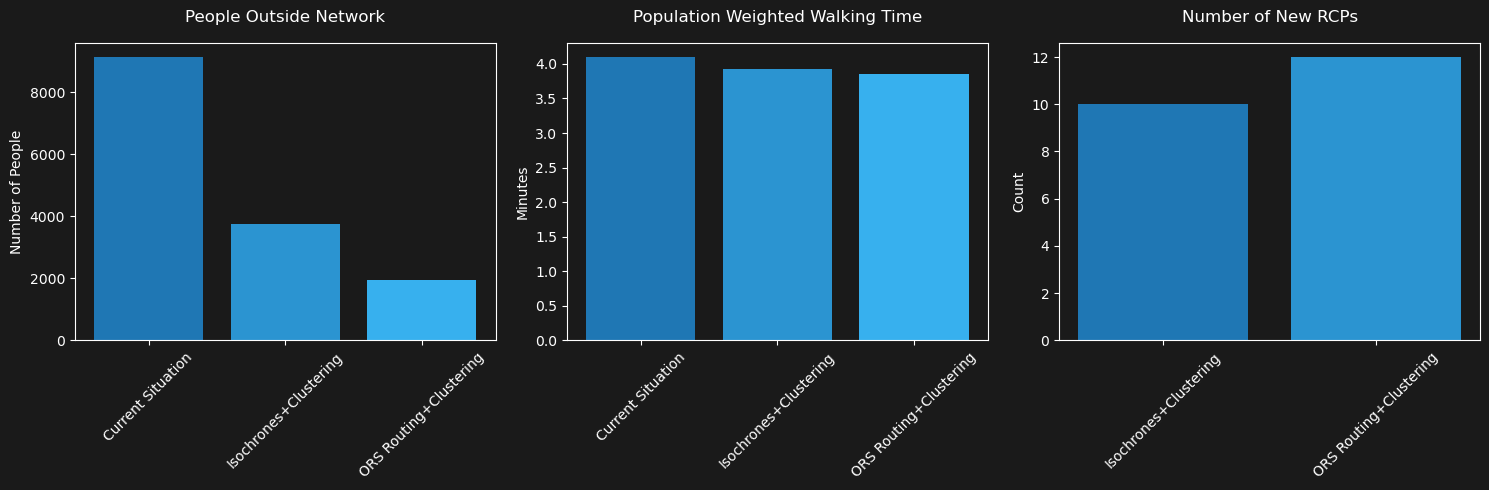

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Define comparison of methods data
methods = ['Current Situation', 'Isochrones+Clustering', 'ORS Routing+Clustering', 'Linear Optimization']
people_outside = [9138, 3767, 1933, 0]  # Replace 'None' with 0
coverage = [98.9, 99.2, 99.6, 0]        # Replace 'None' with 0
walking_times = [4.1, 3.93, 3.85, 0]    # Replace 'None' with 0
new_rcps = [0, 10, 12, 0]               # Replace 'None' with 0




# Set dark theme style
plt.style.use('dark_background')

# Define blue color palette
colors = ['#1f77b4', '#2b94d1', '#37b0ee']

# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
fig.patch.set_facecolor('#1a1a1a')

# Plot 1: People outside the network
ax1.bar(methods[0:3], people_outside[0:3], color=colors)
ax1.set_title('People Outside Network', pad=15)
ax1.set_ylabel('Number of People')
ax1.tick_params(axis='x', rotation=45)
ax1.set_facecolor('#1a1a1a')

# Plot 2: Walking time
ax2.bar(methods[0:3], walking_times[0:3], color=colors)
ax2.set_title('Population Weighted Walking Time', pad=15)
ax2.set_ylabel('Minutes')
ax2.tick_params(axis='x', rotation=45)
ax2.set_facecolor('#1a1a1a')

# Plot 3: Number of New RCPs
ax3.bar(methods[1:3], new_rcps[1:3], color=colors)
ax3.set_title('Number of New RCPs', pad=15)
ax3.set_ylabel('Count')
ax3.tick_params(axis='x', rotation=45)
ax3.set_facecolor('#1a1a1a')

# save plot
plt.savefig('../data/derived_data/method_comparison.png', dpi=400, bbox_inches='tight')

plt.tight_layout()
plt.show()

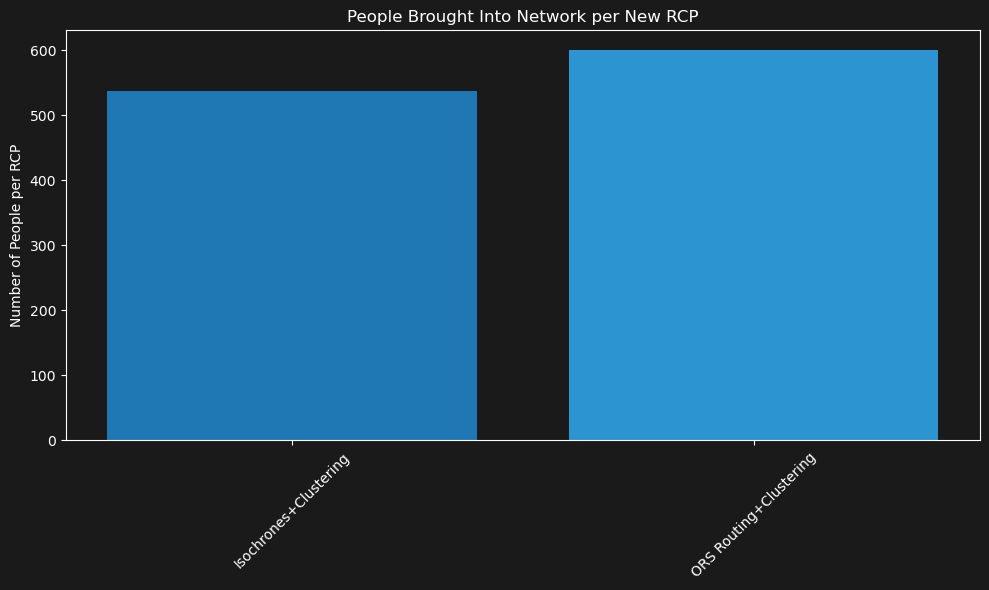

In [29]:
# Calculate people brought in per new RCP
people_per_rcp = [people_brought_in[i]/new_rcps[i] if new_rcps[i] != 0 else 0 for i in range(1,3)]

# Create a new figure
plt.figure(figsize=(10, 6), facecolor='#1a1a1a')

# Plot the data
plt.bar(methods[1:3], people_per_rcp, color=colors[0:2])

# Customize the plot
plt.title('People Brought Into Network per New RCP')
plt.ylabel('Number of People per RCP')
plt.xticks(rotation=45)
plt.gca().set_facecolor('#1a1a1a')
plt.gca().tick_params(colors='white')
plt.gca().spines['bottom'].set_color('white')
plt.gca().spines['top'].set_color('white')
plt.gca().spines['left'].set_color('white')
plt.gca().spines['right'].set_color('white')
plt.title('People Brought Into Network per New RCP', color='white')
plt.ylabel('Number of People per RCP', color='white')
plt.xticks(color='white')
plt.tight_layout()

# Save the plot
plt.savefig('../data/derived_data/people_brought_in_per_rcp.png', dpi=400, bbox_inches='tight', facecolor='#1a1a1a')

# Show the plot
plt.show()